In [ ]:
!pip install hvsrpy

In [6]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import obspy
import os
import glob

import hvsrpy
from hvsrpy import utils


In [7]:
### Time Domain Settings

windowlength = 60

filter_bool = False       
filter_flow = 0.1                   
filter_fhigh = 10                  
filter_order = 5

# Width of cosine taper {0. - 1.}. Geopsy default of 0.05 is equal to 0.1 -> 0.1 is recommended
# 余弦锥度宽度 {0. - 1.}。 Geopsy 默认值 0.05 等于 0.1 -> 建议使用 0.1
width = 0.1

### Frequency Domain Settings

# Konno and Ohmachi smoothing constant. 40 is recommended.
bandwidth = 40
# Minimum frequency after resampling
resample_fmin = 0.1
# Maximum frequency after resampling
resample_fmax = 10
# Number of frequencies after resampling 重采样后的频率点数
resample_fnum = 1000
# Type of resampling {'log', 'linear'}
resample_type = 'linear'
# Upper and lower frequency limits to restrict peak selection. To use the entire range use `None`.
peak_f_lower = None
peak_f_upper = None


### HVSR Settings

# Method for combining horizontal components {"squared-average", "geometric-mean", "single-azimuth"}.
# Geopsy's default is "squared-average" -> "geometric-mean" is recommended.
method = "geometric-mean"
# If method="single-azimuth", set azimuth in degree clock-wise from north. If method!="single-azimuth", value is ignored.
azimuth = 0

# Boolean to control whether frequency domain rejection proposed by Cox et al. (2020) is applied.
# Geopsy does not offer this functionality.
rejection_bool = True
# Number of standard deviations to consider during rejection. Smaller values will reject more windows -> 2 is recommended.
n = 2
# Maximum number of iterations to perform for rejection -> 50 is recommended.
max_iterations = 50

# Distribution of f0 {"lognormal", "normal"}. Geopsy default "normal" -> "lognormal" is recommended.
distribution_f0 = "lognormal"
# Distribution of mean curve {"lognormal", "normal"}. Geopsy default "lognormal" -> "lognormal" is recommended.
distribution_mc = "lognormal"


### Plot Settings

# Manually set the ylimits of the HVSR figures. Default is None so limits will be set automatically.
ymin, ymax = None, None

Elapsed Time: 1.47 seconds


Text(0, 0.5, 'HVSR Amplitude')

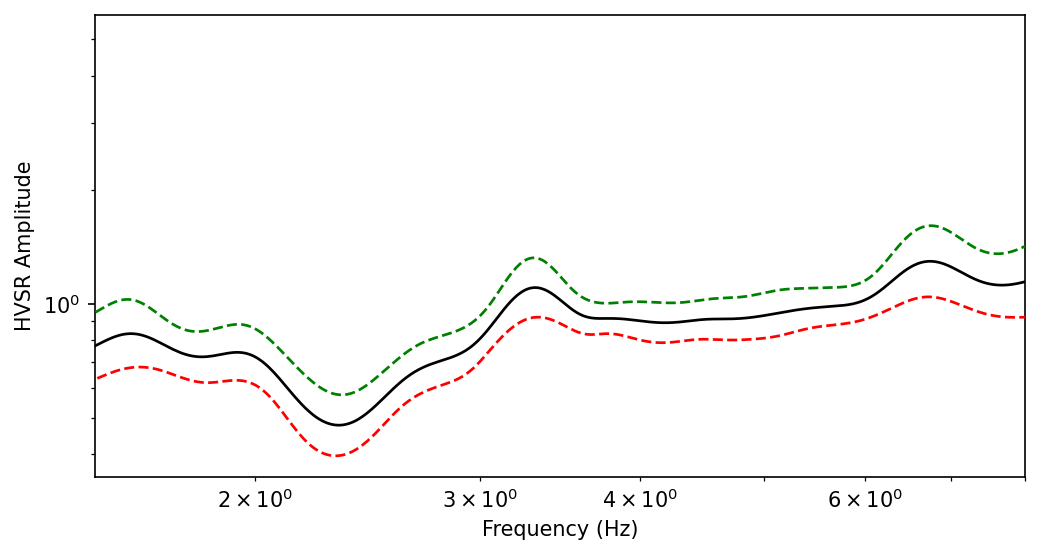

In [8]:
#file_name = '../../inSightDataProcess/DATA/2.4_HZ/C/S0423d/S0423d_VEL.mseed'
#file_name = 'data_copy.mseed'
file_name = '../../inSightDataProcess/DATA/2.4_HZ/B/S0460a/S0460a_VEL.mseed'

fig = plt.figure(figsize=(8, 4), dpi=150)
ax = fig.add_subplot(1, 1, 1)

start = time.time()
sensor = hvsrpy.Sensor3c.from_mseed(file_name)
bp_filter = {"flag":filter_bool, "flow":filter_flow, "fhigh":filter_fhigh, "order":filter_order}
resampling = {"minf":resample_fmin, "maxf":resample_fmax, "nf":resample_fnum, "res_type":resample_type}
hv = sensor.hv(windowlength, bp_filter, width, bandwidth, resampling, method, f_low=peak_f_lower, f_high=peak_f_upper, azimuth=azimuth)
end = time.time()
print(f"Elapsed Time: {str(end-start)[0:4]} seconds")

individual_width = 0.3
median_width = 1.3
title="Before Rejection"

# Mean Curve 
ax.plot(hv.frq, hv.mean_curve(distribution_mc), color='k', linewidth=median_width)

# Mean +/- Curve
ax.plot(hv.frq, hv.nstd_curve(-1, distribution_mc),
        color='r', linestyle='--', linewidth=median_width, zorder=3)
ax.plot(hv.frq, hv.nstd_curve(+1, distribution_mc),
        color='g', linestyle='--', linewidth=median_width, zorder=3)


ax.set_xlim(1.5, 8.)
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("HVSR Amplitude")

In [9]:
fname = os.path.basename(file_name).split('.')[0]
# np 按列合并
hv_data = np.column_stack((hv.frq, hv.mean_curve(distribution_mc)))
np.savetxt(fname+'.hv', hv_data)